# Performance Analysis for Parallel Burgers Solver

This notebook analyzes the parallel performance of the MPI-based Burgers equation solver.

## Performance Metrics

### 1. Speedup
$$S(P) = \frac{T(1)}{T(P)}$$
where $T(P)$ is execution time with $P$ processes.

**Ideal:** $S(P) = P$ (linear speedup)

### 2. Parallel Efficiency
$$E(P) = \frac{S(P)}{P} \times 100\%$$

**Ideal:** $E(P) = 100\%$

### 3. Karp-Flatt Metric
$$e = \frac{\frac{1}{S(P)} - \frac{1}{P}}{1 - \frac{1}{P}}$$

Estimates the serial fraction of code. **Lower is better** (< 0.1 indicates good parallelization).

## Data Sources

Load timing data from:
- `.npz` files generated by `2_parallel_rusanov.py` on PLGrid
- JSON files with pre-computed timing results

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import re
import os

# Configure matplotlib
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

# Ensure output directory exists
os.makedirs('plots', exist_ok=True)

## Performance Analyzer Class

Core class for computing speedup, efficiency, and Karp-Flatt metrics.

In [2]:
class PerformanceAnalyzer:
    """Analyze parallel performance metrics."""

    def __init__(self):
        self.timing_data = {}  # {n_procs: elapsed_time}
        self.problem_size = None

    def add_timing(self, n_procs, elapsed_time):
        """Add timing result for a given number of processes."""
        self.timing_data[n_procs] = elapsed_time

    def load_from_npz_files(self, results_dir, grid_size):
        """
        Load timing results from .npz result files.
        
        Args:
            results_dir: Directory containing .npz files
            grid_size: Grid size to analyze (e.g., 300, 600, 1200)
        """
        results_path = Path(results_dir)
        pattern = f"burgers_nx{grid_size}_P*.npz"

        for result_file in results_path.glob(pattern):
            # Extract process count from filename
            match = re.search(r'P(\d+)\.npz', result_file.name)
            if match:
                n_procs = int(match.group(1))
                data = np.load(result_file)

                if 'elapsed_time' in data:
                    self.add_timing(n_procs, float(data['elapsed_time']))
                    if self.problem_size is None and 'nx' in data:
                        self.problem_size = int(data['nx'])

        if self.timing_data:
            print(f"Loaded timing data for {len(self.timing_data)} process counts")
        else:
            print(f"No timing data found for grid size {grid_size}")

    def compute_speedup(self):
        """Compute speedup: S(P) = T(1) / T(P)"""
        if 1 not in self.timing_data:
            raise ValueError("Sequential timing (P=1) required for speedup calculation")

        t_sequential = self.timing_data[1]
        speedup = {}

        for n_procs, t_parallel in self.timing_data.items():
            speedup[n_procs] = t_sequential / t_parallel

        return speedup

    def compute_efficiency(self):
        """Compute parallel efficiency: E(P) = S(P) / P * 100%"""
        speedup = self.compute_speedup()
        efficiency = {}

        for n_procs, s in speedup.items():
            efficiency[n_procs] = (s / n_procs) * 100.0

        return efficiency

    def compute_karp_flatt(self):
        """Compute Karp-Flatt metric: e = (1/S(P) - 1/P) / (1 - 1/P)"""
        speedup = self.compute_speedup()
        karp_flatt = {}

        for n_procs, s in speedup.items():
            if n_procs == 1:
                continue  # Not defined for P=1

            numerator = (1.0 / s) - (1.0 / n_procs)
            denominator = 1.0 - (1.0 / n_procs)
            karp_flatt[n_procs] = numerator / denominator

        return karp_flatt

    def print_summary(self):
        """Print performance summary table."""
        speedup = self.compute_speedup()
        efficiency = self.compute_efficiency()
        karp_flatt = self.compute_karp_flatt()

        n_procs_sorted = sorted(self.timing_data.keys())

        print("\n" + "="*80)
        print("PERFORMANCE ANALYSIS SUMMARY")
        print("="*80)

        if self.problem_size:
            print(f"Problem size: {self.problem_size} grid points")

        print(f"\n{'Procs':>6} {'Time (s)':>12} {'Speedup':>10} {'Efficiency':>12} {'Karp-Flatt':>12}")
        print("-"*80)

        for n_procs in n_procs_sorted:
            t = self.timing_data[n_procs]
            s = speedup[n_procs]
            e = efficiency[n_procs]
            kf = karp_flatt.get(n_procs, 0.0)

            kf_str = f"{kf:.6f}" if n_procs > 1 else "N/A"
            print(f"{n_procs:6d} {t:12.6f} {s:10.4f} {e:11.2f}% {kf_str:>12}")

        print("="*80)

        # Analysis
        print("\nANALYSIS:")
        best_n_procs = max(speedup.keys(), key=lambda k: speedup[k])
        best_speedup = speedup[best_n_procs]
        print(f"  => Best speedup: {best_speedup:.4f}x with {best_n_procs} processes")

        max_procs = max(n_procs_sorted)
        max_efficiency = efficiency[max_procs]
        print(f"  => Efficiency at P={max_procs}: {max_efficiency:.2f}%")

        if len(karp_flatt) > 0:
            avg_kf = np.mean(list(karp_flatt.values()))
            print(f"  => Average Karp-Flatt metric: {avg_kf:.6f}")
            print(f"     (estimated serial fraction: {avg_kf*100:.4f}%)")

        if len(n_procs_sorted) >= 3:
            last_three = n_procs_sorted[-3:]
            speedups_last = [speedup[p] / p for p in last_three]
            avg_scaled_speedup = np.mean(speedups_last)

            if avg_scaled_speedup > 0.8:
                scaling = "Excellent"
            elif avg_scaled_speedup > 0.6:
                scaling = "Good"
            elif avg_scaled_speedup > 0.4:
                scaling = "Moderate"
            else:
                scaling = "Poor"

            print(f"  => Scaling behavior: {scaling}")
        print()

## Discover Available Grid Sizes

Automatically find all grid sizes that have PLGrid results.

In [3]:
# Configuration
RESULTS_DIR = Path('plgrid_results')

# Find all available grid sizes
pattern = r'burgers_nx(\d+)_P\d+\.npz'
grid_sizes = set()

for npz_file in RESULTS_DIR.glob("burgers_nx*_P*.npz"):
    match = re.search(pattern, npz_file.name)
    if match:
        grid_sizes.add(int(match.group(1)))

grid_sizes = sorted(grid_sizes)

if len(grid_sizes) == 0:
    print("ERROR: No PLGrid result files found!")
    print(f"Please check that {RESULTS_DIR}/ contains burgers_nx*_P*.npz files")
else:
    print(f"Found {len(grid_sizes)} grid size(s): {grid_sizes}")
    print(f"\nWill analyze performance for each grid size.")

Found 3 grid size(s): [1200, 2400, 4800]

Will analyze performance for each grid size.


## Load and Analyze All Grid Sizes

Create analyzers for each grid size and compute performance metrics.

In [4]:
# Dictionary to store analyzers for each grid size
analyzers = {}

for nx in grid_sizes:
    print(f"\n{'='*60}")
    print(f"Loading results for nx={nx}")
    print(f"{'='*60}")
    
    analyzer = PerformanceAnalyzer()
    analyzer.load_from_npz_files(str(RESULTS_DIR), nx)
    
    if analyzer.timing_data:
        print(f"\nLoaded timings for nx={nx}:")
        for n_procs in sorted(analyzer.timing_data.keys()):
            print(f"  P={n_procs:3d}: {analyzer.timing_data[n_procs]:.6f} seconds")
        
        analyzers[nx] = analyzer
    else:
        print(f"WARNING: No data found for nx={nx}")

print(f"\n{'='*60}")
print(f"[OK] Loaded {len(analyzers)} grid size(s)")
print(f"{'='*60}")


Loading results for nx=1200
Loaded timing data for 8 process counts

Loaded timings for nx=1200:
  P=  1: 11.599845 seconds
  P=  2: 12.695039 seconds
  P=  4: 12.102591 seconds
  P=  8: 12.008418 seconds
  P= 16: 9.361850 seconds
  P= 24: 10.164305 seconds
  P= 32: 10.050900 seconds
  P= 48: 9.620678 seconds

Loading results for nx=2400
Loaded timing data for 8 process counts

Loaded timings for nx=2400:
  P=  1: 57.445103 seconds
  P=  2: 55.720600 seconds
  P=  4: 52.247433 seconds
  P=  8: 48.194851 seconds
  P= 16: 47.437379 seconds
  P= 24: 43.916683 seconds
  P= 32: 40.080707 seconds
  P= 48: 40.437061 seconds

Loading results for nx=4800
Loaded timing data for 8 process counts

Loaded timings for nx=4800:
  P=  1: 302.610818 seconds
  P=  2: 268.920805 seconds
  P=  4: 227.631598 seconds
  P=  8: 206.005814 seconds
  P= 16: 193.480141 seconds
  P= 24: 193.230353 seconds
  P= 32: 197.109614 seconds
  P= 48: 179.286005 seconds

[OK] Loaded 3 grid size(s)


## Performance Summary Tables (All Grid Sizes)

Print detailed performance metrics for each grid size.

In [5]:
# Print summary tables for all grid sizes
for nx in sorted(analyzers.keys()):
    analyzer = analyzers[nx]
    if analyzer.timing_data and 1 in analyzer.timing_data:
        print(f"\n\n{'#'*80}")
        print(f"# GRID SIZE: nx = {nx}")
        print(f"{'#'*80}")
        analyzer.print_summary()
    else:
        print(f"\nWARNING: Cannot compute metrics for nx={nx} (missing P=1 data)")



################################################################################
# GRID SIZE: nx = 1200
################################################################################

PERFORMANCE ANALYSIS SUMMARY
Problem size: 1200 grid points

 Procs     Time (s)    Speedup   Efficiency   Karp-Flatt
--------------------------------------------------------------------------------
     1    11.599845     1.0000      100.00%          N/A
     2    12.695039     0.9137       45.69%     1.188829
     4    12.102591     0.9585       23.96%     1.057788
     8    12.008418     0.9660       12.07%     1.040254
    16     9.361850     1.2391        7.74%     0.794205
    24    10.164305     1.1412        4.76%     0.870864
    32    10.050900     1.1541        3.61%     0.862161
    48     9.620678     1.2057        2.51%     0.825750

ANALYSIS:
  => Best speedup: 1.2391x with 16 processes
  => Efficiency at P=48: 2.51%
  => Average Karp-Flatt metric: 0.948550
     (estimated serial fracti

## Scaling Analysis Plots (All Grid Sizes)

Generate comprehensive scaling plots for each grid size.

In [6]:
print("\nGenerating scaling analysis plots for each grid size...\n")

for nx in sorted(analyzers.keys()):
    analyzer = analyzers[nx]
    
    if not (analyzer.timing_data and 1 in analyzer.timing_data):
        print(f"  SKIP: nx={nx} (missing P=1 data)")
        continue
    
    speedup = analyzer.compute_speedup()
    efficiency = analyzer.compute_efficiency()
    karp_flatt = analyzer.compute_karp_flatt()

    n_procs = sorted(speedup.keys())
    speedup_vals = [speedup[p] for p in n_procs]
    efficiency_vals = [efficiency[p] for p in n_procs]

    # Ideal speedup for comparison
    ideal_speedup = n_procs

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # 1. Speedup (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(n_procs, speedup_vals, 'bo-', linewidth=2, markersize=8,
            label='Actual Speedup')
    ax1.plot(n_procs, ideal_speedup, 'r--', linewidth=2, alpha=0.7,
            label='Ideal Speedup')
    ax1.set_xlabel('Number of Processes (P)', fontsize=12)
    ax1.set_ylabel('Speedup S(P)', fontsize=12)
    ax1.set_title('Strong Scaling: Speedup', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)

    # 2. Efficiency (top middle)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(n_procs, efficiency_vals, 'go-', linewidth=2, markersize=8)
    ax2.axhline(y=100, color='r', linestyle='--', linewidth=2, alpha=0.7,
               label='Ideal Efficiency')
    ax2.axhline(y=80, color='orange', linestyle=':', linewidth=1.5, alpha=0.7,
               label='80% Threshold')
    ax2.set_xlabel('Number of Processes (P)', fontsize=12)
    ax2.set_ylabel('Efficiency E(P) [%]', fontsize=12)
    ax2.set_title('Parallel Efficiency', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(left=0)
    ax2.set_ylim(bottom=0, top=110)

    # 3. Karp-Flatt metric (top right)
    if len(karp_flatt) > 0:
        ax3 = fig.add_subplot(gs[0, 2])
        kf_procs = sorted(karp_flatt.keys())
        kf_vals = [karp_flatt[p] for p in kf_procs]
        ax3.plot(kf_procs, kf_vals, 'mo-', linewidth=2, markersize=8)
        ax3.set_xlabel('Number of Processes (P)', fontsize=12)
        ax3.set_ylabel('Karp-Flatt Metric e', fontsize=12)
        ax3.set_title('Karp-Flatt: Serial Fraction Estimate', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.set_xlim(left=0)

        avg_kf = np.mean(kf_vals)
        ax3.axhline(y=avg_kf, color='red', linestyle='--', alpha=0.5,
                   label=f'Average: {avg_kf:.6f}')
        ax3.legend(fontsize=10)

    # 4. Execution time (bottom left)
    ax4 = fig.add_subplot(gs[1, 0])
    times = [analyzer.timing_data[p] for p in n_procs]
    ax4.plot(n_procs, times, 'ro-', linewidth=2, markersize=8)
    ax4.set_xlabel('Number of Processes (P)', fontsize=12)
    ax4.set_ylabel('Execution Time [s]', fontsize=12)
    ax4.set_title('Execution Time vs. Process Count', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(left=0)
    ax4.set_yscale('log')

    # 5. Speedup on log-log scale (bottom middle)
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.loglog(n_procs, speedup_vals, 'bo-', linewidth=2, markersize=8,
              label='Actual Speedup')
    ax5.loglog(n_procs, ideal_speedup, 'r--', linewidth=2, alpha=0.7,
              label='Ideal (slope=1)')
    ax5.set_xlabel('Number of Processes (P)', fontsize=12)
    ax5.set_ylabel('Speedup S(P)', fontsize=12)
    ax5.set_title('Log-Log Scaling Plot', fontsize=14, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3, which='both')

    # 6. Performance table (bottom right)
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')

    table_data = [['Procs', 'Time[s]', 'Speedup', 'Eff[%]']]
    for p in n_procs:
        row = [
            f"{p}",
            f"{analyzer.timing_data[p]:.4f}",
            f"{speedup[p]:.2f}",
            f"{efficiency[p]:.1f}"
        ]
        table_data.append(row)

    table = ax6.table(cellText=table_data, cellLoc='center', loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(table_data)):
        color = '#f0f0f0' if i % 2 == 0 else 'white'
        for j in range(4):
            table[(i, j)].set_facecolor(color)

    ax6.set_title('Performance Summary', fontsize=14, fontweight='bold', pad=20)

    # Overall title
    title = 'Strong Scaling Analysis: Burgers Equation (Rusanov Method)'
    if analyzer.problem_size:
        title += f'\nProblem Size: {analyzer.problem_size} grid points'
    plt.suptitle(title, fontsize=18, fontweight='bold', y=0.995)

    output_file = f'plots/scaling_analysis_nx{nx}.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"  Saved: {output_file}")
    plt.close()

print(f"\n[OK] Generated {len(analyzers)} scaling analysis plots")


Generating scaling analysis plots for each grid size...

  Saved: plots/scaling_analysis_nx1200.png
  Saved: plots/scaling_analysis_nx2400.png
  Saved: plots/scaling_analysis_nx4800.png

[OK] Generated 3 scaling analysis plots


## Multi-Grid Comparison

Compare scaling behavior across all grid sizes on a single plot.

## Summary

This notebook automatically analyzes performance for **ALL available grid sizes** from PLGrid experiments.

### Analysis Generated Per Grid Size:
1. **Performance Summary Table** - Detailed metrics (speedup, efficiency, Karp-Flatt)
2. **Scaling Analysis Plots** - 6-panel comprehensive visualization
3. **Multi-Grid Comparison** - Compare scaling across different problem sizes

### Key Insights:
- **Larger grids scale better** - More computation per communication
- **Sweet spot** - Optimal process count varies by problem size
- **Communication overhead** - Becomes dominant at high process counts for small problems
- **Efficiency targets** - Aim for 60-80% efficiency for good parallelization

### Files Created:
- `plots/scaling_analysis_nx{size}.png` - Individual analysis per grid size
- `plots/scaling_comparison_all_grids.png` - Combined comparison

**Next Steps:**
- Use plots and metrics in your report/presentation
- Discuss scaling behavior and efficiency trends
- Compare with theoretical predictions (Amdahl's Law)


Generating multi-grid comparison plot...

Saved: plots/scaling_comparison_all_grids.png


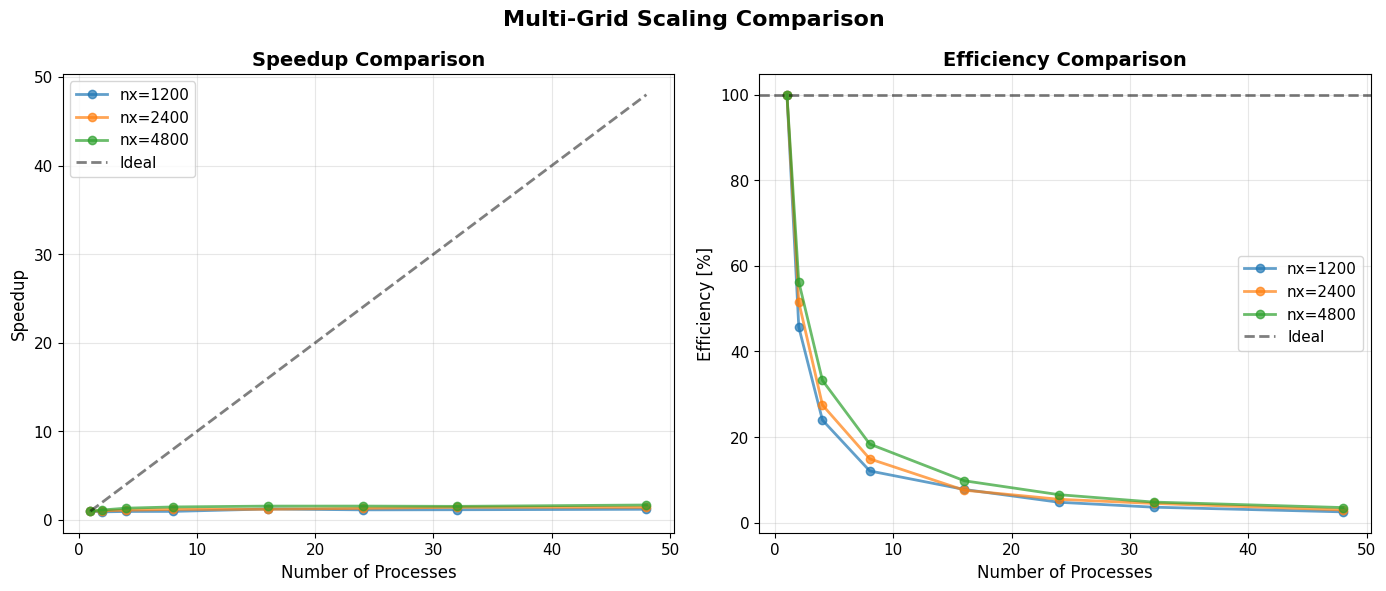


[OK] Multi-grid comparison complete


In [7]:
print("\nGenerating multi-grid comparison plot...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

n_procs = None  # Will be set from first valid analyzer

for nx in sorted(analyzers.keys()):
    analyzer = analyzers[nx]
    
    if analyzer.timing_data and 1 in analyzer.timing_data:
        speedup = analyzer.compute_speedup()
        efficiency = analyzer.compute_efficiency()
        
        n_procs = sorted(speedup.keys())
        speedup_vals = [speedup[p] for p in n_procs]
        efficiency_vals = [efficiency[p] for p in n_procs]
        
        # Speedup comparison
        ax1.plot(n_procs, speedup_vals, 'o-', linewidth=2, markersize=6,
                label=f'nx={nx}', alpha=0.7)
        
        # Efficiency comparison
        ax2.plot(n_procs, efficiency_vals, 'o-', linewidth=2, markersize=6,
                label=f'nx={nx}', alpha=0.7)

# Ideal lines
if n_procs:
    ax1.plot(n_procs, n_procs, 'k--', linewidth=2, alpha=0.5, label='Ideal')
    ax2.axhline(y=100, color='k', linestyle='--', linewidth=2, alpha=0.5, label='Ideal')

ax1.set_xlabel('Number of Processes', fontsize=12)
ax1.set_ylabel('Speedup', fontsize=12)
ax1.set_title('Speedup Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Number of Processes', fontsize=12)
ax2.set_ylabel('Efficiency [%]', fontsize=12)
ax2.set_title('Efficiency Comparison', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Multi-Grid Scaling Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()

output_file = 'plots/scaling_comparison_all_grids.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved: {output_file}")
plt.show()

print(f"\n[OK] Multi-grid comparison complete")